# Fully Connected vs. Convolutional Neural Networks

## Refs 

https://www.tensorflow.org/install

https://www.tensorflow.org/tutorials/keras/classification
    

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo
# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util

import numpy as np
import matplotlib.pyplot as plt
import time

# Auxiliary functions

In [9]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)


def show_histories():

    # summarize history for accuracy
    plt.plot(history_IV['accuracy'])
    plt.plot(history_C['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['model FC', 'model Conv'], loc='lower right')
    plt.show()


def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(4)

    models = ['model 1', 'model 2', 'model 3', 'model 4']
    plt.bar(X, eval_acc, width = 0.4, color = 'b', label='eval')
    plt.bar(X + 0.4, train_acc, color = 'r', width = 0.4, label = "train")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom =95)
    plt.legend(loc='lower right')
    plt.show()    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model_IV(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds)        

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

epochs = 3

cuda:0


## Load MNIST dataset

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

batch_size = 128

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False)

## Display a few images

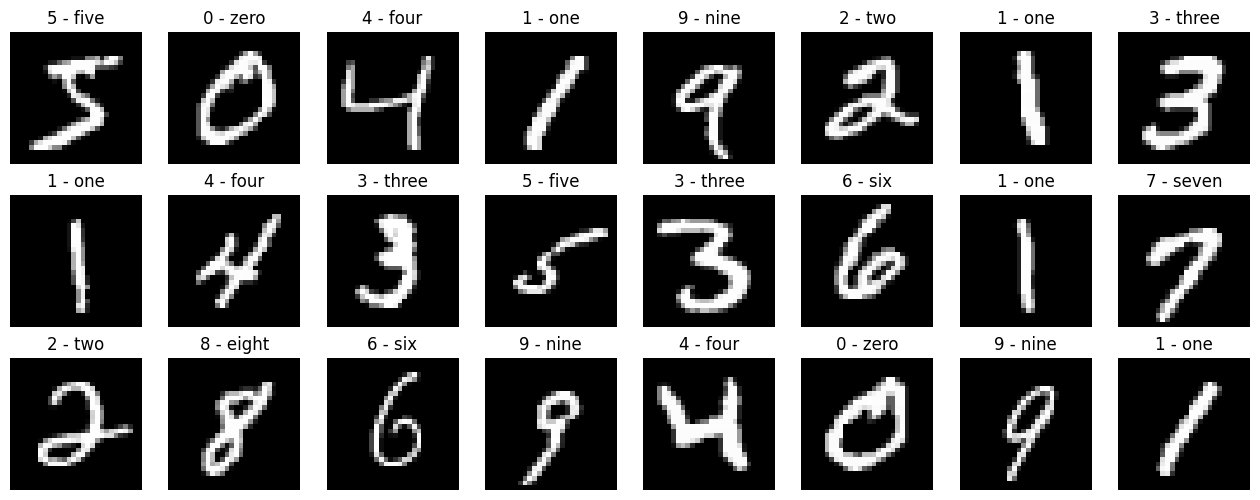

<Figure size 640x480 with 0 Axes>

In [12]:
images, targets = next(iter(train_loader))

# these are the transformed images
vcpi_util.show_transformed_images(3,8, train_set, train_set.classes) 

# Build and train a fully connected model

In [13]:
class FullyConnected_IV(torch.nn.Module):

    def __init__(self,num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256,128)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(128,64)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(64,num_classes)
        

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)

        return(x)

In [14]:
model_IV = FullyConnected_IV(len(train_set.classes))
model_IV.to(device)
print(model_IV)

torchinfo.summary(model_IV, input_size=(batch_size, 1, 28, 28))

FullyConnected_IV(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_IV                        [128, 10]                 --
├─Linear: 1-1                            [128, 256]                200,960
├─ReLU: 1-2                              [128, 256]                --
├─Linear: 1-3                            [128, 128]                32,896
├─ReLU: 1-4                              [128, 128]                --
├─Linear: 1-5                            [128, 64]                 8,256
├─ReLU: 1-6                              [128, 64]                 --
├─Linear: 1-7                            [128, 10]                 650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
Total mult-adds (M): 31.07
Input size (MB): 0.40
Forward/backward pass size (MB): 0.47
Params size (MB): 0.97
Estimated Total Size (MB): 1.84

## Load model

In [15]:
optimizer_IV = torch.optim.Adam(model_IV.parameters())

retrieved = torch.load(f'model_IV_50.pt')
    
model_IV.load_state_dict(retrieved['model'])
model_IV.to(device)

optimizer_IV.load_state_dict(retrieved['optimizer'])
history_IV = retrieved['history']


## Evaluate Model

In [16]:
evaluate(model_IV, test_loader)


0.9817000031471252

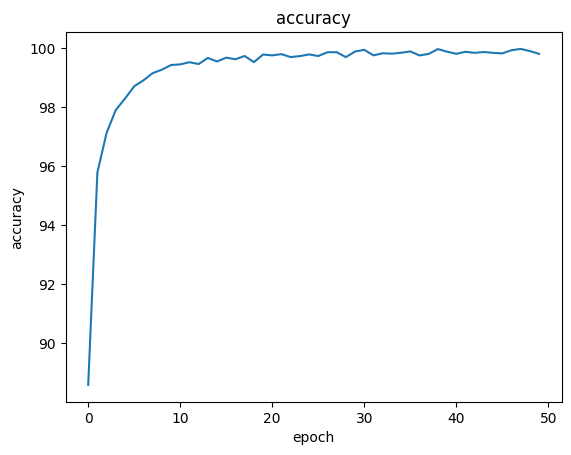

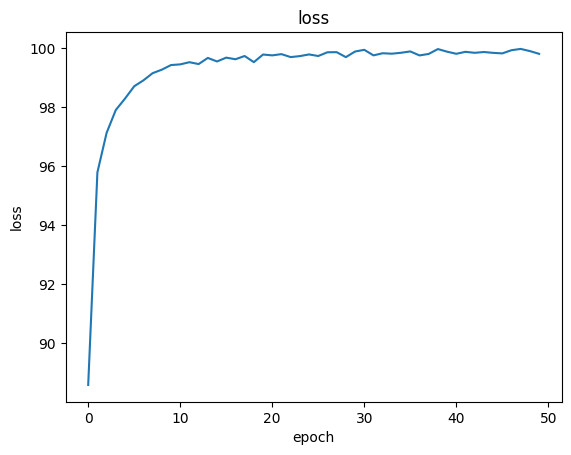

In [17]:
vcpi_util.show_history(history_IV)

In [18]:
class Conv(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.relu3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.relu4 = torch.nn.ReLU()
        
        self.fc1 = torch.nn.Linear(19200, 10) # 48 * 20 * 20 = 19200
    
    def forward(self, x):
        # input (bs, 1, 28, 28)
        x = self.conv1(x) # (bs, 16, 26, 26)
        x = self.relu1(x)
        x = self.conv2(x) # (bs, 32, 24, 24)
        x = self.relu2(x)
        x = self.conv3(x) # (bs, 48, 22, 22)
        x = self.relu3(x)
        x = self.conv4(x) # (bs, 48, 20, 20)
        x = self.relu4(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        return x

In [19]:
model_conv = Conv()
model_conv.to(device)
print(model_conv)

torchinfo.summary(model_conv, input_size=(batch_size, 1, 28, 28))

Conv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (fc1): Linear(in_features=19200, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─ReLU: 1-2                              [128, 16, 26, 26]         --
├─Conv2d: 1-3                            [128, 32, 24, 24]         4,640
├─ReLU: 1-4                              [128, 32, 24, 24]         --
├─Conv2d: 1-5                            [128, 48, 22, 22]         13,872
├─ReLU: 1-6                              [128, 48, 22, 22]         --
├─Conv2d: 1-7                            [128, 48, 20, 20]         20,784
├─ReLU: 1-8                              [128, 48, 20, 20]         --
├─Linear: 1-9                            [128, 10]                 192,010
Total params: 231,466
Trainable params: 231,466
Non-trainable params: 0
Total mult-adds (G): 2.30
Input size (MB): 0.40
Forward/backward pass size (MB): 73.41
Params size (MB): 0.93
Estimated Total Size (MB):

In [20]:
evaluate(model_conv, test_loader)

0.09309999644756317

In [21]:
optimizer_C = torch.optim.Adam(model_conv.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
history_C = train(model_conv, train_loader, 20, loss_fn, optimizer_C)

Epoch: 000; Accuracy = 94.1817; Elapsed time: 29.5067
Epoch: 001; Accuracy = 98.2533; Elapsed time: 28.1824
Epoch: 002; Accuracy = 98.8350; Elapsed time: 25.8441
Epoch: 003; Accuracy = 99.0467; Elapsed time: 25.8703
Epoch: 004; Accuracy = 99.3017; Elapsed time: 26.0793
Epoch: 005; Accuracy = 99.4067; Elapsed time: 26.0153
Epoch: 006; Accuracy = 99.5617; Elapsed time: 25.5340
Epoch: 007; Accuracy = 99.6217; Elapsed time: 26.5568
Epoch: 008; Accuracy = 99.6817; Elapsed time: 20.2455
Epoch: 009; Accuracy = 99.6967; Elapsed time: 20.9348
Epoch: 010; Accuracy = 99.7233; Elapsed time: 20.1749
Epoch: 011; Accuracy = 99.7417; Elapsed time: 20.3921
Epoch: 012; Accuracy = 99.8133; Elapsed time: 20.1703
Epoch: 013; Accuracy = 99.8667; Elapsed time: 20.1671
Epoch: 014; Accuracy = 99.8633; Elapsed time: 20.0956
Epoch: 015; Accuracy = 99.8633; Elapsed time: 20.1357
Epoch: 016; Accuracy = 99.8433; Elapsed time: 19.8999
Epoch: 017; Accuracy = 99.8650; Elapsed time: 19.9927
Epoch: 018; Accuracy = 99.88

In [22]:
evaluate(model_conv, test_loader)

0.9886000156402588